In [49]:
from torch import torch, nn, optim
import torch.nn.functional as F

In [50]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Get the data
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [51]:
# Create the network, define loss function and optimizer
model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim=1))

loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

## Training

In [52]:
# Train the network
epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #Flattening the input
        # images.shape[0] is gonna give us our batch size
        # -1 is gonna fill out the 2nd dimension with as many elements as it needs
        x = images.view(images.shape[0], -1)
        
        #Clear the gradient
        optimizer.zero_grad()
        
        #Training
        y_hat = model.forward(x)
        loss = loss_func(y_hat, labels)
        loss.backward()
        optimizer.step()
        
        running_loss = running_loss + loss.item()
    else:
        print(f'Training loss: {running_loss}')

Training loss: 480.18246053159237
Training loss: 362.9822806119919
Training loss: 329.96811901032925
Training loss: 307.64146760851145
Training loss: 296.09570321440697


## Inference and Validation

In [53]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

dataiter = iter(testloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [81]:
# Create the network, define loss function and optimizer
model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim=1))

loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [82]:
epochs = 20
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for training_images, training_labels in trainloader:
        x_train = training_images.view(training_images.shape[0], -1)
        
        optimizer.zero_grad()
        
        #Training
        y_hat_train = model.forward(x_train)
        training_loss = loss_func(y_hat_train, training_labels)
        training_loss.backward()
        optimizer.step()
        
        running_loss = running_loss + training_loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        #Inference
        #Turn off gradients for validation
        with torch.no_grad():
            running_test_loss = 0
            for test_images, test_labels in testloader:
                x_test = test_images.view(test_images.shape[0], -1)
                
                y_hat_test = model.forward(x_test)
                test_loss = loss_func(y_hat_test, test_labels)
                running_test_loss = running_test_loss + test_loss.item()
                
                ps = torch.exp(y_hat_test)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == test_labels.view(*top_class.shape)
                accuracy = accuracy + torch.mean(equals.type(torch.FloatTensor))
                
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(running_test_loss/len(testloader))
            
            print("Epochs: {}/{}.. ".format(e+1, epochs),
                 "Training Loss: {:.3f}..".format(running_loss/len(trainloader)),
                 "Test Loss: {:.3f}..".format(running_test_loss/len(testloader)),
                 "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epochs: 1/20..  Training Loss: 0.507.. Test Loss: 0.432.. Test Accuracy: 0.842
Epochs: 2/20..  Training Loss: 0.387.. Test Loss: 0.398.. Test Accuracy: 0.857
Epochs: 3/20..  Training Loss: 0.352.. Test Loss: 0.390.. Test Accuracy: 0.859
Epochs: 4/20..  Training Loss: 0.331.. Test Loss: 0.381.. Test Accuracy: 0.865
Epochs: 5/20..  Training Loss: 0.312.. Test Loss: 0.405.. Test Accuracy: 0.847
Epochs: 6/20..  Training Loss: 0.300.. Test Loss: 0.398.. Test Accuracy: 0.862
Epochs: 7/20..  Training Loss: 0.289.. Test Loss: 0.386.. Test Accuracy: 0.871
Epochs: 8/20..  Training Loss: 0.281.. Test Loss: 0.356.. Test Accuracy: 0.877
Epochs: 9/20..  Training Loss: 0.274.. Test Loss: 0.376.. Test Accuracy: 0.873
Epochs: 10/20..  Training Loss: 0.261.. Test Loss: 0.392.. Test Accuracy: 0.870
Epochs: 11/20..  Training Loss: 0.256.. Test Loss: 0.392.. Test Accuracy: 0.875
Epochs: 12/20..  Training Loss: 0.249.. Test Loss: 0.375.. Test Accuracy: 0.879
Epochs: 13/20..  Training Loss: 0.244.. Test Loss

In [83]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

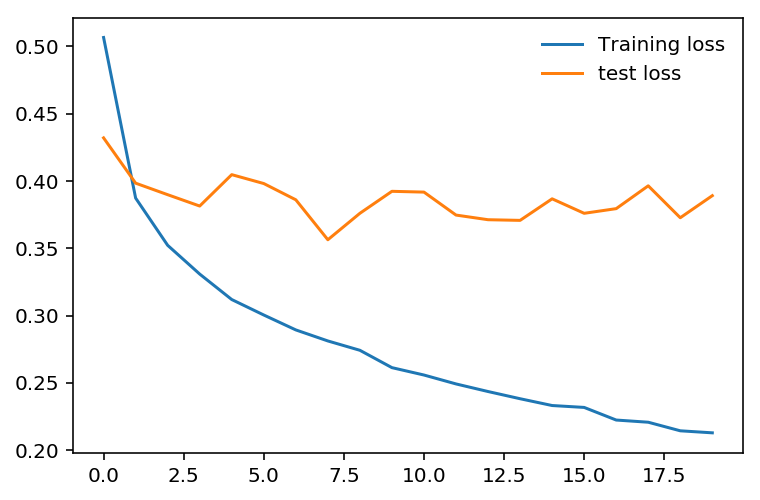

In [84]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='test loss')
plt.legend(frameon=False)

## Overfitting

The sign that the model is overfitting is when the validation error starts to get worse

### Dropout

In [85]:
# Create the network, define loss function and optimizer
model_with_dropout = nn.Sequential(nn.Dropout(p=0.5),
                                   nn.Linear(784, 512),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.5),
                                   nn.Linear(512, 256),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.5),
                                   nn.Linear(256, 128),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.5),
                                   nn.Linear(128, 64),
                                   nn.ReLU(),
                                   nn.Linear(64,10),
                                   nn.LogSoftmax(dim=1))

loss_func = nn.NLLLoss()
optimizer = optim.Adam(model_with_dropout.parameters(), lr=0.001)

In [86]:
epochs = 20
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    
    #Training pass
    for training_images, training_labels in trainloader:
        x_train = training_images.view(training_images.shape[0], -1)
        
        optimizer.zero_grad()
        
        #Training
        y_hat_train = model_with_dropout.forward(x_train)
        training_loss = loss_func(y_hat_train, training_labels)
        training_loss.backward()
        optimizer.step()
        
        running_loss = running_loss + training_loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        #Inference
        #Turn off gradients for validation
        with torch.no_grad():
            
            # set model to evaluation mode (e.g. No Dropout)
            model_with_dropout.eval()
            
            # Validation pass through the test data
            running_test_loss = 0
            for test_images, test_labels in testloader:
                x_test = test_images.view(test_images.shape[0], -1)
                
                y_hat_test = model_with_dropout.forward(x_test)
                test_loss = loss_func(y_hat_test, test_labels)
                running_test_loss = running_test_loss + test_loss.item()
                
                ps = torch.exp(y_hat_test)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == test_labels.view(*top_class.shape)
                accuracy = accuracy + torch.mean(equals.type(torch.FloatTensor))
            
            #Set the model to training mode again so to have dropout on 
            model_with_dropout.train()
            
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(running_test_loss/len(testloader))
            
            print("Epochs: {}/{}.. ".format(e+1, epochs),
                 "Training Loss: {:.3f}..".format(running_loss/len(trainloader)),
                 "Test Loss: {:.3f}..".format(running_test_loss/len(testloader)),
                 "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epochs: 1/20..  Training Loss: 0.814.. Test Loss: 0.528.. Test Accuracy: 0.811
Epochs: 2/20..  Training Loss: 0.621.. Test Loss: 0.485.. Test Accuracy: 0.824
Epochs: 3/20..  Training Loss: 0.587.. Test Loss: 0.477.. Test Accuracy: 0.827
Epochs: 4/20..  Training Loss: 0.568.. Test Loss: 0.452.. Test Accuracy: 0.838
Epochs: 5/20..  Training Loss: 0.551.. Test Loss: 0.441.. Test Accuracy: 0.840
Epochs: 6/20..  Training Loss: 0.538.. Test Loss: 0.441.. Test Accuracy: 0.842
Epochs: 7/20..  Training Loss: 0.535.. Test Loss: 0.433.. Test Accuracy: 0.846
Epochs: 8/20..  Training Loss: 0.521.. Test Loss: 0.426.. Test Accuracy: 0.843
Epochs: 9/20..  Training Loss: 0.516.. Test Loss: 0.421.. Test Accuracy: 0.850
Epochs: 10/20..  Training Loss: 0.510.. Test Loss: 0.421.. Test Accuracy: 0.848
Epochs: 11/20..  Training Loss: 0.502.. Test Loss: 0.404.. Test Accuracy: 0.854
Epochs: 12/20..  Training Loss: 0.502.. Test Loss: 0.399.. Test Accuracy: 0.855
Epochs: 13/20..  Training Loss: 0.500.. Test Loss

In [87]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

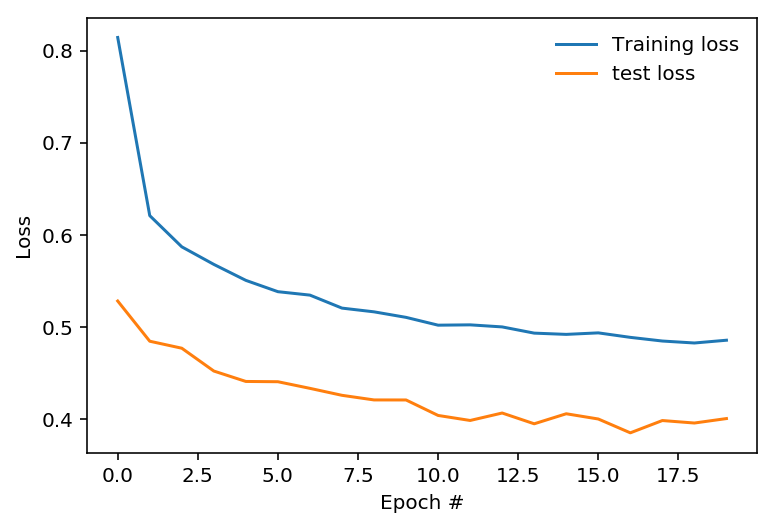

In [88]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(frameon=False)